In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn.linear_model import LinearRegression, Lasso, LassoCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, RandomForestClassifier, ExtraTreesClassifier, AdaBoostRegressor, GradientBoostingRegressor, AdaBoostClassifier, GradientBoostingClassifier, BaggingRegressor, BaggingClassifier

import time

In [3]:
df = pd.read_csv('../Project4/Data/clean.csv').drop(columns = ['Unnamed: 0', 'released'])
df.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,month
0,The Shining,4.0,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0,June
1,The Blue Lagoon,4.0,Adventure,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0,July
2,Star Wars: Episode V - The Empire Strikes Back,2.0,Action,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0,June
3,Airplane!,2.0,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0,July
4,Caddyshack,4.0,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0,July


In [4]:
df.shape

(7475, 15)

In [5]:
df.isnull().sum()

name           0
rating        53
genre          0
year           0
score          0
votes          0
director       0
writer         0
star           0
country        0
budget      2040
gross          0
company        0
runtime        1
month          0
dtype: int64

#### We will need to impute rating and runtime, then budget

Only one value for runtime missing, and according to imdb, it's 91 minutes: https://www.imdb.com/title/tt1598828/

In [6]:
df[df['runtime'].isna()]

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,month
6019,One for the Money,3.0,Action,2012,5.3,41000.0,Julie Anne Robinson,Stacy Sherman,Katherine Heigl,United States,40000000.0,38084162.0,Lakeshore Entertainment,NaN,January


In [7]:
df['runtime'].fillna(91, inplace = True)

In [8]:
df[df['name'] == 'One for the Money']

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,month
6019,One for the Money,3.0,Action,2012,5.3,41000.0,Julie Anne Robinson,Stacy Sherman,Katherine Heigl,United States,40000000.0,38084162.0,Lakeshore Entertainment,91.0,January


In [9]:
df['rating'].value_counts(normalize = True, dropna = False).reset_index().sort_values('rating')

,rating,proportion
4,1.0,0.020334
2,2.0,0.163880
1,3.0,0.279866
0,4.0,0.484682
6,5.0,0.003478
3,6.0,0.040669
5,NaN,0.007090


In [10]:
df['runtime'].mean(), df['runtime'].median(), df['runtime'].mode()

(107.44588628762541,
 104.0,
 0    97.0
 Name: runtime, dtype: float64)

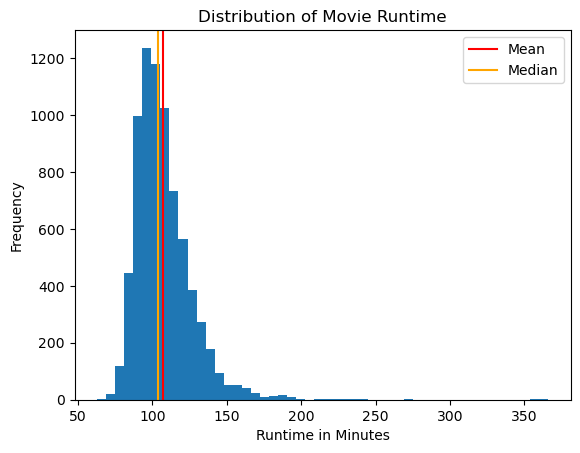

In [11]:
plt.hist(df['runtime'], bins = 50);
plt.xlabel('Runtime in Minutes')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Runtime');
plt.axvline(df['runtime'].mean(), color = 'red', label = 'Mean')
plt.axvline(df['runtime'].median(), color = 'orange', label = 'Median')
plt.legend()

plt.savefig('./Images/distribution_of_movie_runtimes.png', dpi = 192)

In [12]:
df['rating'].value_counts(dropna = False)

rating
4.0    3623
3.0    2092
2.0    1225
6.0     304
1.0     152
NaN      53
5.0      26
Name: count, dtype: int64

In [13]:
df.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,month
0,The Shining,4.0,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0,June
1,The Blue Lagoon,4.0,Adventure,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0,July
2,Star Wars: Episode V - The Empire Strikes Back,2.0,Action,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0,June
3,Airplane!,2.0,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0,July
4,Caddyshack,4.0,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0,July


#### Look at Runtime and Budget by Rating

In [14]:
rating_mapping = {1 : "G", 2: "PG", 3 : "PG-13", 4 : "R", 5 : "NC-17", 6 : "Unrated"}
df['rating_labels'] = df['rating'].map(rating_mapping)
df.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,month,rating_labels
0,The Shining,4.0,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0,June,R
1,The Blue Lagoon,4.0,Adventure,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0,July,R
2,Star Wars: Episode V - The Empire Strikes Back,2.0,Action,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0,June,PG
3,Airplane!,2.0,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0,July,PG
4,Caddyshack,4.0,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0,July,R


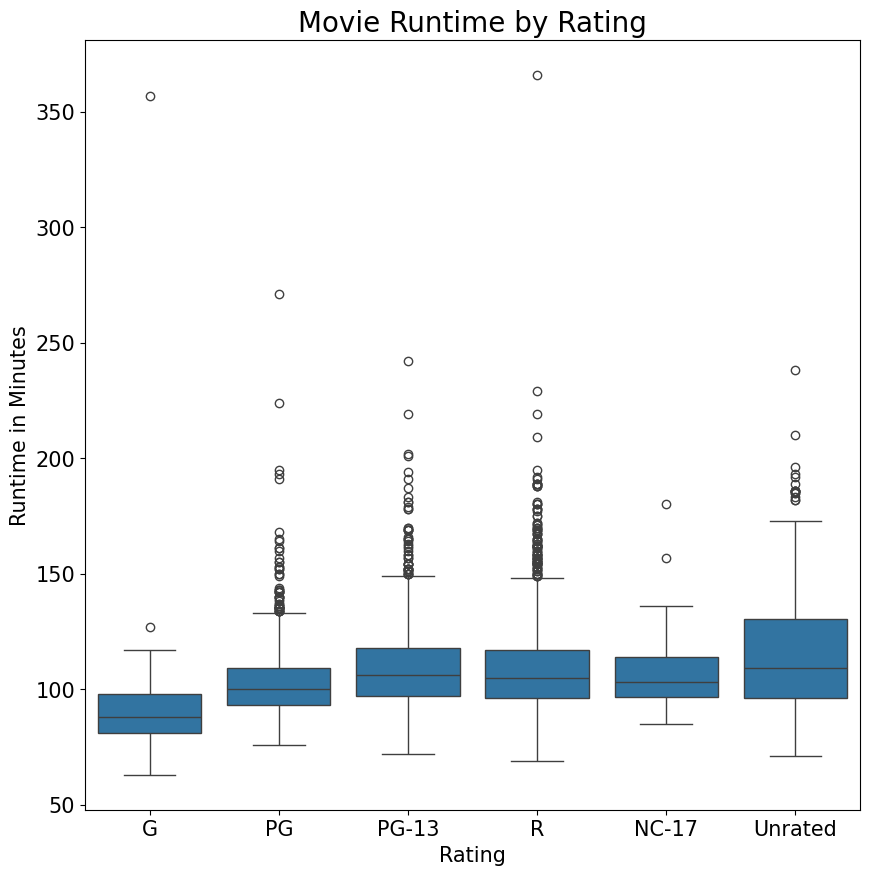

In [15]:
# Sort the ratings so we can see the length of movies by the rating
df_sorted = df.sort_values(by = 'rating')

plt.figure(figsize = (10,10))
sns.boxplot(data = df_sorted, x = 'rating_labels', y = 'runtime')

plt.xlabel('Rating', fontsize = 15)
plt.ylabel('Runtime in Minutes', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Movie Runtime by Rating', fontsize = 20)

plt.savefig('./Images/movie_runtime_by_rating.png', dpi = 192)

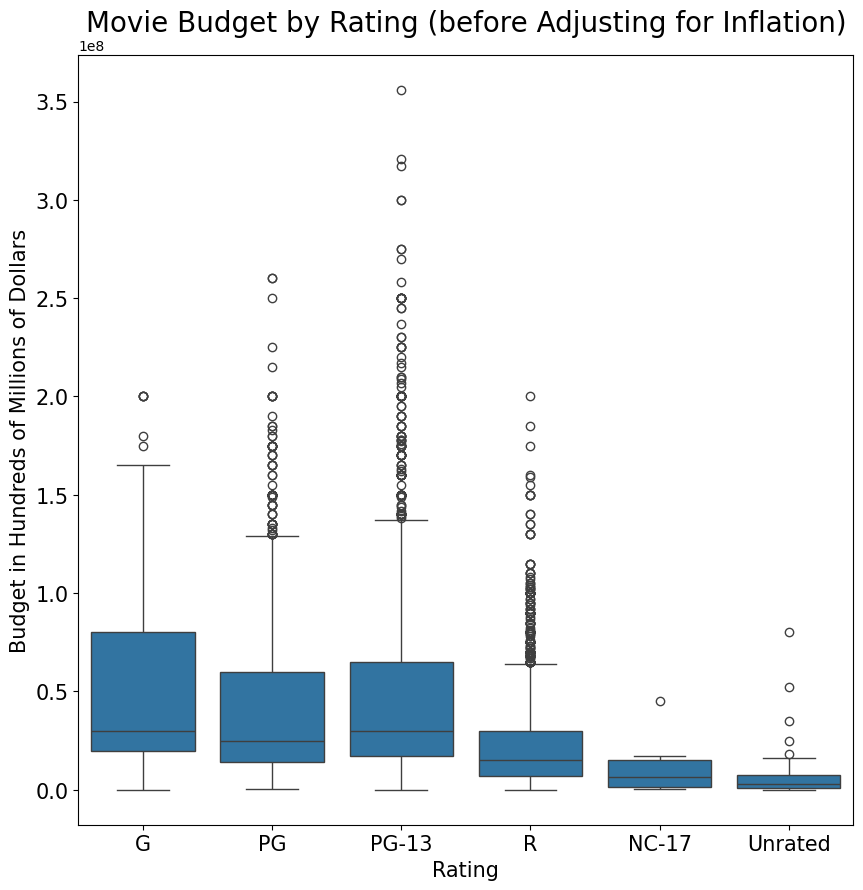

In [16]:
df_sorted = df.sort_values(by = 'rating')

plt.figure(figsize = (10,10))
sns.boxplot(data = df_sorted, x = 'rating_labels', y = 'budget')

plt.xlabel('Rating', fontsize = 15)
plt.ylabel('Budget in Hundreds of Millions of Dollars', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Movie Budget by Rating (before Adjusting for Inflation)', fontsize = 20)

plt.savefig('./Images/movie_budget_by_rating_(before_inflation).png', dpi = 192)

### Look at Runtime and Budget by Genre

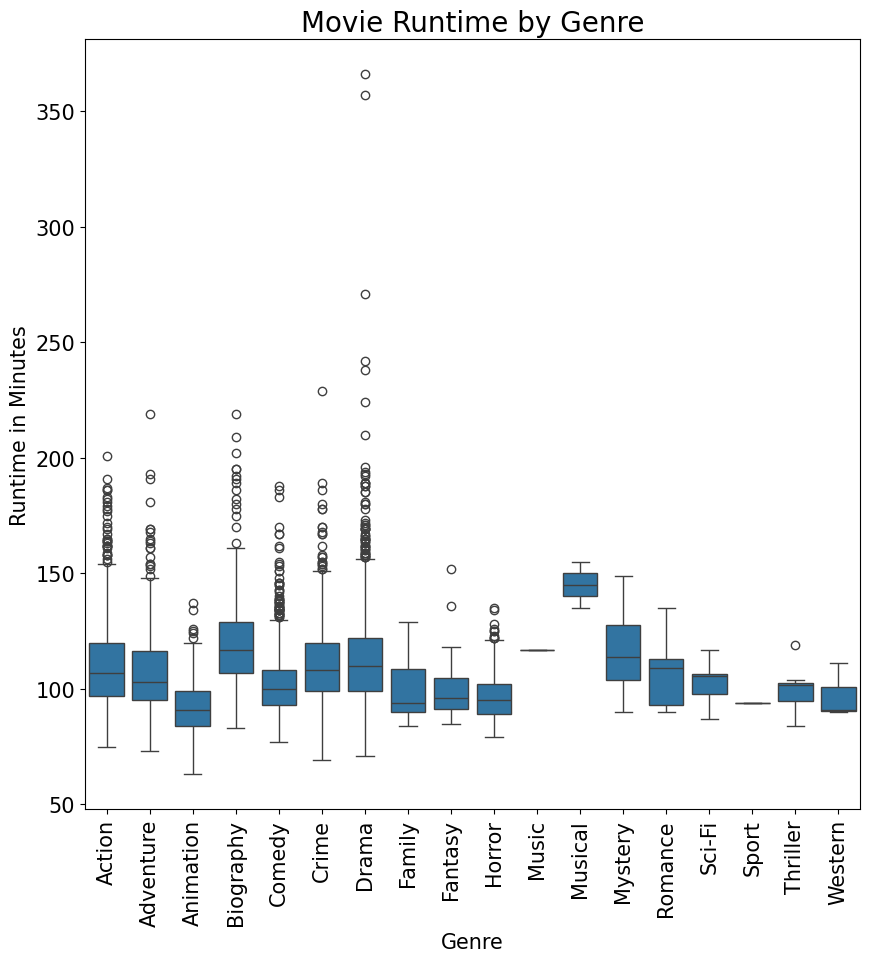

In [17]:
genre_sort = df.sort_values(by = 'genre')

plt.figure(figsize = (10,10))
sns.boxplot(data = genre_sort, x = 'genre', y = 'runtime')

plt.xlabel('Genre', fontsize = 15)
plt.ylabel('Runtime in Minutes', fontsize = 15)
plt.xticks(fontsize = 15, rotation = 90)
plt.yticks(fontsize = 15)
plt.title('Movie Runtime by Genre', fontsize = 20)

plt.savefig('./Images/movie_runtime_by_genre.png', dpi = 192);

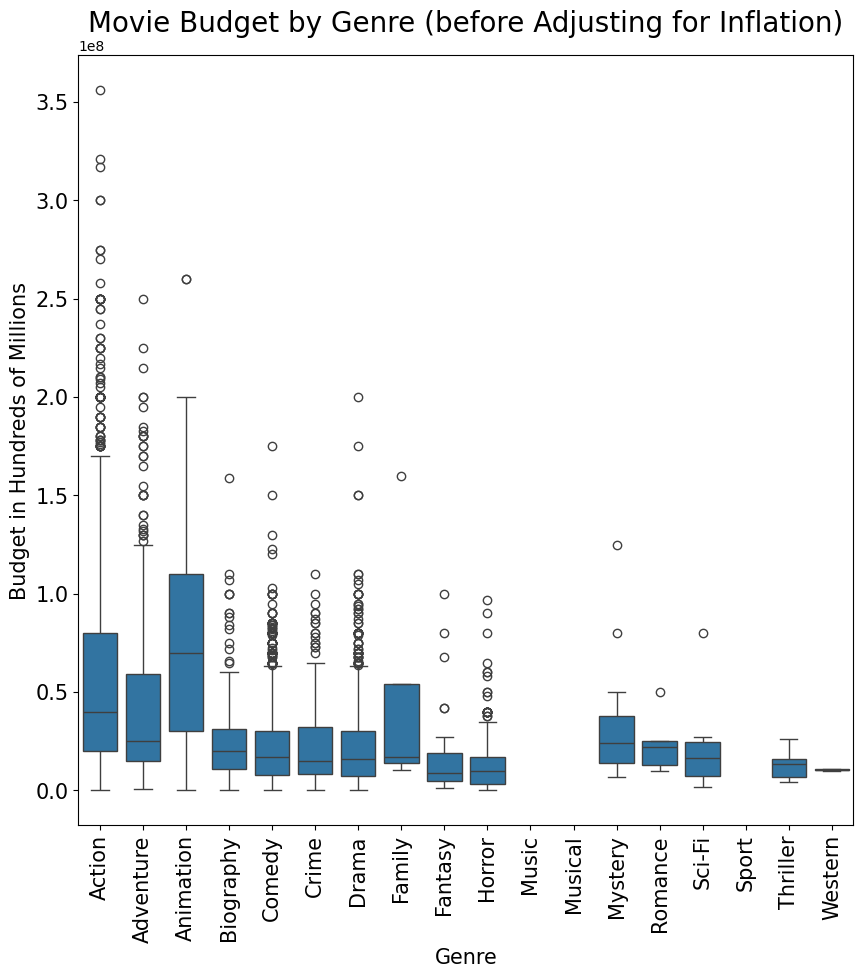

In [18]:
genre_sort = df.sort_values(by = 'genre')

plt.figure(figsize = (10,10))
sns.boxplot(data = genre_sort, x = 'genre', y = 'budget')

plt.xlabel('Genre', fontsize = 15)
plt.ylabel('Budget in Hundreds of Millions', fontsize = 15)
plt.xticks(fontsize = 15, rotation = 90)
plt.yticks(fontsize = 15)
plt.title('Movie Budget by Genre (before Adjusting for Inflation)', fontsize = 20)

plt.savefig('./Images/movie_budget_by_genre_before_inflation.png', dpi = 192);

## Imputing Rating

In [19]:
df.isnull().sum()

name                0
rating             53
genre               0
year                0
score               0
votes               0
director            0
writer              0
star                0
country             0
budget           2040
gross               0
company             0
runtime             0
month               0
rating_labels      53
dtype: int64

In [20]:
have_rating = df[df['rating'].notnull()]
have_rating.isnull().sum()

name                0
rating              0
genre               0
year                0
score               0
votes               0
director            0
writer              0
star                0
country             0
budget           1998
gross               0
company             0
runtime             0
month               0
rating_labels       0
dtype: int64

In [21]:
# Drop gross since that's part of what we're trying to measure by looking at the net;
# Drop budget since it also has missing values
# Dropped director, writer, star -- too many permutations that made it too long to run the model
X = have_rating.drop(columns = ['name', 'rating', 'budget', 'rating_labels', 'gross', 'writer', 'director', 'star'])
y = have_rating['rating']

X.head()

,genre,year,score,votes,country,company,runtime,month
0,Drama,1980,8.4,927000.0,United Kingdom,Warner Bros.,146.0,June
1,Adventure,1980,5.8,65000.0,United States,Columbia Pictures,104.0,July
2,Action,1980,8.7,1200000.0,United States,Lucasfilm,124.0,June
3,Comedy,1980,7.7,221000.0,United States,Paramount Pictures,88.0,July
4,Comedy,1980,7.3,108000.0,United States,Orion Pictures,98.0,July


In [22]:
X.dtypes

genre       object
year         int64
score      float64
votes      float64
country     object
company     object
runtime    float64
month       object
dtype: object

In [23]:
X.shape

(7422, 8)

In [24]:
y.head()

0    4.0
1    4.0
2    2.0
3    2.0
4    4.0
Name: rating, dtype: float64

In [25]:
y.value_counts(normalize = True, dropna = False)

rating
4.0    0.488143
3.0    0.281865
2.0    0.165050
6.0    0.040959
1.0    0.020480
5.0    0.003503
Name: proportion, dtype: float64

In [26]:
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = True)

In [27]:
ctx = ColumnTransformer(
    transformers = [ ('one_hot', ohe, ['genre', 'country', 'company', 'month'])], remainder = 'passthrough',
    verbose_feature_names_out = False)

In [28]:
have_genre_ohe = ctx.fit_transform(X)

In [29]:
have_genre_ohe

<7422x2336 sparse matrix of type '<class 'numpy.float64'>'
	with 57698 stored elements in Compressed Sparse Row format>

In [30]:
# Before dropping writer/director/star, was 12,164 columns - this takes it to just 2,330 columns
# 2330 without writer / director / star
have_genre_ohe_df = pd.DataFrame.sparse.from_spmatrix(have_genre_ohe, columns = ctx.get_feature_names_out() )
have_genre_ohe_df

,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Drama,genre_Family,genre_Fantasy,genre_Horror,genre_Music,...,month_June,month_March,month_May,month_November,month_October,month_September,year,score,votes,runtime
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1980.0,8.4,927000.0,146.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1980.0,5.8,65000.0,104.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1980.0,8.7,1200000.0,124.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1980.0,7.7,221000.0,88.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1980.0,7.3,108000.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7417,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020.0,6.8,42000.0,100.0
7418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020.0,6.8,3700.0,149.0
7419,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020.0,5.4,2400.0,98.0
7420,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2020.0,5.0,294.0,120.0


In [31]:
# gb = GradientBoostingClassifier(random_state = 42)

# params = {'n_estimators' : [100, 150, 200],
#           'max_depth' : [None, 5, 10, 20] }

# gs = GridSearchCV(gb, params, cv = 5, n_jobs = -1)

In [32]:
# gs.fit(have_genre_ohe_df, y)

In [33]:
# gs.best_estimator_

In [34]:
# gs.best_params_

In [35]:
# gs.score(have_genre_ohe_df, y)

### Ran the above commented out code through a Grid Search and it said the best parameters were Max Depth: None and N_estimators: 100, with a score of 1.0

To save time in future runs, will just have the model be based on the best parameters

In [36]:
gs = GradientBoostingClassifier(n_estimators = 100, max_depth = None)

gs.fit(have_genre_ohe_df, y)

GradientBoostingClassifier(max_depth=None)

In [37]:
gs.score(have_genre_ohe_df, y)

1.0

In [38]:
no_rating = df[df['rating'].isnull()]
no_rating.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,month,rating_labels
69,Babylon,NaN,Drama,1980,7.4,1300.0,Franco Rosso,Franco Rosso,David N. Haynes,United Kingdom,NaN,109749.0,Diversity Music,95.0,November,NaN
91,Das Boot,NaN,Adventure,1981,8.3,237000.0,Wolfgang Petersen,Wolfgang Petersen,Jürgen Prochnow,West Germany,NaN,11487676.0,Bavaria Film,149.0,February,NaN
276,The State of Things,NaN,Drama,1982,7.0,3000.0,Wim Wenders,Robert Kramer,Allen Garfield,West Germany,NaN,3700.0,Gray City,121.0,February,NaN
462,Nausicaä of the Valley of the Wind,NaN,Animation,1984,8.1,157000.0,Hayao Miyazaki,Hayao Miyazaki,Sumi Shimamoto,Japan,1000000.0,8736506.0,Nibariki,117.0,November,NaN
587,Winter Flight,NaN,Drama,1984,7.3,67.0,Roy Battersby,Alan Janes,Reece Dinsdale,United Kingdom,NaN,2729.0,Enigma Productions,89.0,February,NaN


In [39]:
# Getting the index of the missing values
no_rating_index = df[df['rating'].isnull()].index
no_rating_index

Index([  69,   91,  276,  462,  587,  847,  935, 1124, 1129, 1720, 2032, 2165,
       2167, 2271, 2687, 2836, 2927, 2960, 3025, 3285, 3380, 3620, 3650, 3659,
       3720, 3774, 3788, 4113, 4206, 4250, 4445, 5014, 6527, 6646, 6660, 6806,
       7009, 7259, 7399, 7426, 7430, 7435, 7437, 7438, 7439, 7443, 7445, 7448,
       7453, 7454, 7458, 7460, 7473],
      dtype='int64')

In [40]:
type(no_rating_index)

pandas.core.indexes.base.Index

In [41]:
no_rating.drop(columns = ['name', 'rating', 'director', 'writer', 'star', 'budget', 'gross', 'rating_labels'], inplace = True)
no_rating.head()

C:\Users\david\AppData\Local\Temp\ipykernel_29224\834987550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_rating.drop(columns = ['name', 'rating', 'director', 'writer', 'star', 'budget', 'gross', 'rating_labels'], inplace = True)


,genre,year,score,votes,country,company,runtime,month
69,Drama,1980,7.4,1300.0,United Kingdom,Diversity Music,95.0,November
91,Adventure,1981,8.3,237000.0,West Germany,Bavaria Film,149.0,February
276,Drama,1982,7.0,3000.0,West Germany,Gray City,121.0,February
462,Animation,1984,8.1,157000.0,Japan,Nibariki,117.0,November
587,Drama,1984,7.3,67.0,United Kingdom,Enigma Productions,89.0,February


In [42]:
no_rating_ctx = ctx.transform(no_rating)
no_rating_ctx

C:\Users\david\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


<53x2336 sparse matrix of type '<class 'numpy.float64'>'
	with 389 stored elements in Compressed Sparse Row format>

In [43]:
no_rating_ctx_df = pd.DataFrame.sparse.from_spmatrix(no_rating_ctx, columns = ctx.get_feature_names_out(), index = no_rating_index)
no_rating_ctx_df.head()

,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Drama,genre_Family,genre_Fantasy,genre_Horror,genre_Music,...,month_June,month_March,month_May,month_November,month_October,month_September,year,score,votes,runtime
69,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1980.0,7.4,1300.0,95.0
91,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1981.0,8.3,237000.0,149.0
276,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1982.0,7.0,3000.0,121.0
462,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1984.0,8.1,157000.0,117.0
587,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1984.0,7.3,67.0,89.0


In [44]:
rating_preds = gs.predict(no_rating_ctx_df.loc[no_rating_index, no_rating_ctx_df.columns])
rating_preds

array([2., 2., 4., 4., 4., 4., 4., 2., 4., 4., 4., 4., 2., 4., 4., 4., 4.,
       4., 4., 4., 3., 6., 4., 6., 4., 4., 2., 4., 4., 6., 4., 6., 6., 6.,
       6., 4., 6., 6., 4., 2., 6., 4., 6., 4., 6., 6., 2., 6., 6., 6., 4.,
       3., 6.])

In [45]:
type(rating_preds)

numpy.ndarray

In [46]:
len(rating_preds)

53

In [47]:
no_rating.index

Index([  69,   91,  276,  462,  587,  847,  935, 1124, 1129, 1720, 2032, 2165,
       2167, 2271, 2687, 2836, 2927, 2960, 3025, 3285, 3380, 3620, 3650, 3659,
       3720, 3774, 3788, 4113, 4206, 4250, 4445, 5014, 6527, 6646, 6660, 6806,
       7009, 7259, 7399, 7426, 7430, 7435, 7437, 7438, 7439, 7443, 7445, 7448,
       7453, 7454, 7458, 7460, 7473],
      dtype='int64')

In [48]:
len(no_rating.index)

53

In [49]:
# Use .loc to find the rows in the original df where the row has the same index as those with no rating, and then call the column rating and fill it with rating_preds
df.loc[no_rating.index, 'rating'] = rating_preds

### Added a column to indicate if the rating was imputed or not

In [50]:
df['rating_imputed'] = 0

df.loc[no_rating.index, 'rating'] = 1

df.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,month,rating_labels,rating_imputed
0,The Shining,4.0,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0,June,R,0
1,The Blue Lagoon,4.0,Adventure,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0,July,R,0
2,Star Wars: Episode V - The Empire Strikes Back,2.0,Action,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0,June,PG,0
3,Airplane!,2.0,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0,July,PG,0
4,Caddyshack,4.0,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0,July,R,0


In [51]:
df['rating'].value_counts(dropna = False)

rating
4.0    3623
3.0    2092
2.0    1225
6.0     304
1.0     205
5.0      26
Name: count, dtype: int64

In [52]:
df.isna().sum()

name                 0
rating               0
genre                0
year                 0
score                0
votes                0
director             0
writer               0
star                 0
country              0
budget            2040
gross                0
company              0
runtime              0
month                0
rating_labels       53
rating_imputed       0
dtype: int64

### Impute the Budget

In [53]:
df.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,month,rating_labels,rating_imputed
0,The Shining,4.0,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0,June,R,0
1,The Blue Lagoon,4.0,Adventure,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0,July,R,0
2,Star Wars: Episode V - The Empire Strikes Back,2.0,Action,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0,June,PG,0
3,Airplane!,2.0,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0,July,PG,0
4,Caddyshack,4.0,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0,July,R,0


In [54]:
have_budget = df[df['budget'].notnull()]
no_budget = df[df['budget'].isnull()]
have_budget.shape, no_budget.shape

((5435, 17), (2040, 17))

In [55]:
# Create X and y - drop the columns we aren't using to impute the budget.
X = have_budget.drop(columns = ['name', 'budget', 'rating_labels', 'gross', 'writer', 'director', 'star'])
y = have_budget['budget']

In [56]:
X.dtypes

rating            float64
genre              object
year                int64
score             float64
votes             float64
country            object
company            object
runtime           float64
month              object
rating_imputed      int64
dtype: object

In [57]:
X.head()

,rating,genre,year,score,votes,country,company,runtime,month,rating_imputed
0,4.0,Drama,1980,8.4,927000.0,United Kingdom,Warner Bros.,146.0,June,0
1,4.0,Adventure,1980,5.8,65000.0,United States,Columbia Pictures,104.0,July,0
2,2.0,Action,1980,8.7,1200000.0,United States,Lucasfilm,124.0,June,0
3,2.0,Comedy,1980,7.7,221000.0,United States,Paramount Pictures,88.0,July,0
4,4.0,Comedy,1980,7.3,108000.0,United States,Orion Pictures,98.0,July,0


In [58]:
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = True)

ctx = ColumnTransformer(
    transformers = [ ('one_hot', ohe, ['rating', 'genre', 'country', 'company', 'month'])], remainder = 'passthrough',
    verbose_feature_names_out = False)

In [59]:
have_budget_ohe = ctx.fit_transform(X)
have_budget_ohe

<5435x1568 sparse matrix of type '<class 'numpy.float64'>'
	with 47371 stored elements in Compressed Sparse Row format>

In [60]:
have_budget_ohe_df = pd.DataFrame.sparse.from_spmatrix(have_budget_ohe, columns = ctx.get_feature_names_out() )
have_budget_ohe_df

,rating_2.0,rating_3.0,rating_4.0,rating_5.0,rating_6.0,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,...,month_March,month_May,month_November,month_October,month_September,year,score,votes,runtime,rating_imputed
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1980.0,8.4,927000.0,146.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1980.0,5.8,65000.0,104.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1980.0,8.7,1200000.0,124.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1980.0,7.7,221000.0,88.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1980.0,7.3,108000.0,98.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5430,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2020.0,6.6,140000.0,124.0,0.0
5431,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2020.0,6.5,102000.0,99.0,0.0
5432,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2020.0,5.6,53000.0,101.0,0.0
5433,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2020.0,6.8,42000.0,100.0,0.0


In [61]:
no_budget_indices = no_budget.index
no_budget_indices

Index([  16,   19,   24,   25,   26,   29,   30,   31,   33,   37,
       ...
       7457, 7458, 7459, 7460, 7462, 7465, 7471, 7472, 7473, 7474],
      dtype='int64', length=2040)

In [62]:
no_budget_ctx = ctx.transform(no_budget)
no_budget_ctx

C:\Users\david\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


<2040x1568 sparse matrix of type '<class 'numpy.float64'>'
	with 17088 stored elements in Compressed Sparse Row format>

In [63]:
no_budget_ctx_df = pd.DataFrame.sparse.from_spmatrix(no_budget_ctx, columns = ctx.get_feature_names_out(), index = no_budget_indices)
no_budget_ctx_df

,rating_2.0,rating_3.0,rating_4.0,rating_5.0,rating_6.0,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,...,month_March,month_May,month_November,month_October,month_September,year,score,votes,runtime,rating_imputed
16,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1980.0,6.6,21000.0,134.0,0.0
19,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1980.0,6.8,26000.0,111.0,0.0
24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1980.0,6.4,14000.0,132.0,0.0
25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1980.0,6.9,33000.0,102.0,0.0
26,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1980.0,6.5,5100.0,96.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7465,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2020.0,7.4,120000.0,102.0,0.0
7471,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2020.0,5.4,2400.0,98.0,0.0
7472,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2020.0,5.0,294.0,120.0,0.0
7473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2020.0,6.7,903.0,135.0,0.0


In [64]:
lr = LinearRegression()

lr.fit(have_budget_ohe_df, y)

LinearRegression()

In [65]:
no_budget.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,month,rating_labels,rating_imputed
16,Fame,4.0,Drama,1980,6.6,21000.0,Alan Parker,Christopher Gore,Eddie Barth,United States,NaN,21202829.0,Metro-Goldwyn-Mayer (MGM),134.0,May,R,0
19,Stir Crazy,4.0,Comedy,1980,6.8,26000.0,Sidney Poitier,Bruce Jay Friedman,Gene Wilder,United States,NaN,101300000.0,Columbia Pictures,111.0,December,R,0
24,Urban Cowboy,2.0,Drama,1980,6.4,14000.0,James Bridges,Aaron Latham,John Travolta,United States,NaN,46918287.0,Paramount Pictures,132.0,June,PG,0
25,Altered States,4.0,Horror,1980,6.9,33000.0,Ken Russell,Paddy Chayefsky,William Hurt,United States,NaN,19853892.0,Warner Bros.,102.0,December,R,0
26,Little Darlings,4.0,Comedy,1980,6.5,5100.0,Ron Maxwell,Kimi Peck,Tatum O'Neal,United States,NaN,34326249.0,Stephen Friedman/Kings Road Productions,96.0,March,R,0


In [66]:
budget_pred = lr.predict(no_budget_ctx_df.loc[no_budget_indices, no_budget_ctx_df.columns])
budget_pred

array([14104336.0261972 , -1956030.317451  , 31788100.75368905, ...,
       76973626.01246166, 51181145.80342412, 69957923.39549398])

In [67]:
len(budget_pred)

2040

### Creating predictions with negative values - that can't be right

In [68]:
sorted(budget_pred)

[-35051382.20157313,
 -30206458.27344632,
 -28910030.505907774,
 -26738720.83603382,
 -25718163.07712841,
 -23672114.24685383,
 -22807400.253875494,
 -21938705.572255373,
 -21826689.455327034,
 -21664169.711273193,
 -21205111.002278566,
 -20703047.8493433,
 -20486804.15645981,
 -20200199.03784895,
 -19634389.567020655,
 -19539015.071871042,
 -19426471.63120222,
 -19162519.359226227,
 -19059440.33096695,
 -19049322.32649398,
 -18948943.599338055,
 -18843832.48072958,
 -18762460.809504032,
 -18673716.337997198,
 -18026850.626713514,
 -17914128.113361597,
 -17789196.625867844,
 -17293314.55482459,
 -16781335.531513453,
 -16667372.851206303,
 -16594672.983865738,
 -16525096.727457285,
 -16442326.928696156,
 -16389658.475234747,
 -16195530.14251542,
 -15972463.860574007,
 -15836860.261933327,
 -15763447.691245317,
 -15607029.370044708,
 -15590432.464755774,
 -15162541.966767311,
 -15094692.452978373,
 -14908710.380952358,
 -14820917.890334606,
 -14804877.855773687,
 -14763327.891911268,
 -1

In [69]:
#339 of the 2,040 budgets its predicting are below 0
len(budget_pred[budget_pred < 0])

340

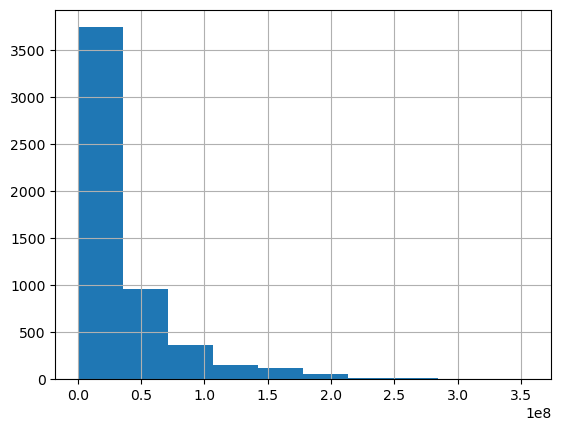

In [70]:
have_budget['budget'].hist();

In [71]:
rf = RandomForestRegressor()

rf_params = {
    'n_estimators' : [100, 150, 200],
    'max_depth' : [None, 5, 10],
    'random_state' : [42]
}

rf_gs = GridSearchCV(rf,
                  param_grid = rf_params,
                  cv = 5)

rf_gs.fit(have_budget_ohe_df, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 5, 10],
                         'n_estimators': [100, 150, 200],
                         'random_state': [42]})

In [72]:
budget_pred2 = rf_gs.predict(no_budget_ctx_df.loc[no_budget_indices, no_budget_ctx_df.columns])
budget_pred2

array([18031500. , 12619000. , 15828500. , ..., 22805900. , 45366225.4,
       15273350. ])

In [73]:
sorted(budget_pred2)

[968652.69,
 977299.995,
 1246174.605,
 1338385.0,
 1448175.0,
 1579889.99,
 1619784.995,
 1691208.07,
 1741880.0,
 1771819.995,
 1794564.995,
 1842925.0,
 1901655.0,
 1949749.995,
 2011374.985,
 2036633.845,
 2177554.985,
 2197305.0,
 2202410.0,
 2266730.0,
 2272169.995,
 2316477.69,
 2404634.995,
 2428395.0,
 2500611.88,
 2567511.88,
 2581100.0,
 2614814.995,
 2630449.995,
 2639445.0,
 2653995.0,
 2676736.88,
 2690461.915,
 2694374.985,
 2725245.0,
 2758350.0,
 2782093.845,
 2786588.45,
 2792031.88,
 2805081.88,
 2808216.88,
 2829018.845,
 2876024.995,
 2879123.76,
 2881914.99,
 2891826.88,
 2913658.845,
 2956850.0,
 2987521.88,
 3005269.985,
 3019238.845,
 3024076.875,
 3077325.0,
 3097370.0,
 3108065.0,
 3125864.995,
 3131339.97,
 3140375.0,
 3187119.995,
 3207961.88,
 3262000.0,
 3268920.0,
 3296720.0,
 3308594.99,
 3309989.995,
 3325044.995,
 3332104.4,
 3348550.0,
 3360013.845,
 3416166.28,
 3442750.0,
 3444045.64,
 3476850.0,
 3505360.64,
 3515514.995,
 3540240.64,
 3557511.88,

In [74]:
type(budget_pred2)

numpy.ndarray

In [75]:
np.median(budget_pred2), np.mean(budget_pred2)

(11115687.7, 13652882.462656863)

#### Imputed Median / Mean Budget Values

In [76]:
'{:,.2f}'.format(np.median(budget_pred2)), '{:,.2f}'.format(np.mean(budget_pred2))

('11,115,687.70', '13,652,882.46')

#### Median / Mean Budget among those with a Budget

In [77]:
'{:,.2f}'.format(have_budget['budget'].median()), '{:,.2f}'.format(have_budget['budget'].mean())

('21,000,000.00', '35,944,790.09')

In [78]:
df.loc[no_budget.index, 'budget'] = budget_pred2
df.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,month,rating_labels,rating_imputed
0,The Shining,4.0,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0,June,R,0
1,The Blue Lagoon,4.0,Adventure,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0,July,R,0
2,Star Wars: Episode V - The Empire Strikes Back,2.0,Action,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0,June,PG,0
3,Airplane!,2.0,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0,July,PG,0
4,Caddyshack,4.0,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0,July,R,0


### Adding a column to indicate if budget is imputed or not

In [79]:
df['budget_imputed'] = 0

df.loc[no_budget.index, 'budget_imputed'] = 1

df.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,month,rating_labels,rating_imputed,budget_imputed
0,The Shining,4.0,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0,June,R,0,0
1,The Blue Lagoon,4.0,Adventure,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0,July,R,0,0
2,Star Wars: Episode V - The Empire Strikes Back,2.0,Action,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0,June,PG,0,0
3,Airplane!,2.0,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0,July,PG,0,0
4,Caddyshack,4.0,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0,July,R,0,0


In [80]:
df[df['budget_imputed'] == 1].head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,month,rating_labels,rating_imputed,budget_imputed
16,Fame,4.0,Drama,1980,6.6,21000.0,Alan Parker,Christopher Gore,Eddie Barth,United States,1.803150e+07,21202829.0,Metro-Goldwyn-Mayer (MGM),134.0,May,R,0,1
19,Stir Crazy,4.0,Comedy,1980,6.8,26000.0,Sidney Poitier,Bruce Jay Friedman,Gene Wilder,United States,1.261900e+07,101300000.0,Columbia Pictures,111.0,December,R,0,1
24,Urban Cowboy,2.0,Drama,1980,6.4,14000.0,James Bridges,Aaron Latham,John Travolta,United States,1.582850e+07,46918287.0,Paramount Pictures,132.0,June,PG,0,1
25,Altered States,4.0,Horror,1980,6.9,33000.0,Ken Russell,Paddy Chayefsky,William Hurt,United States,8.956350e+06,19853892.0,Warner Bros.,102.0,December,R,0,1
26,Little Darlings,4.0,Comedy,1980,6.5,5100.0,Ron Maxwell,Kimi Peck,Tatum O'Neal,United States,5.368065e+06,34326249.0,Stephen Friedman/Kings Road Productions,96.0,March,R,0,1


In [81]:
# create a function to compare histograms of original & imputed data from Missing Data Lesson

# Adjusted the ymax and bins for this data set

def compare_histograms(imputed_column, original_column, x_label, y_label = 'Frequency'):
    fig, (ax0, ax1) = plt.subplots(nrows = 2, ncols = 1, figsize = (16,9))

    # Set axes of histograms.
    mode = statistics.mode(imputed_column)
    rnge = max(original_column) - min(original_column)
    xmin = min(original_column) - 0.02 * rnge
    xmax = max(original_column) + 0.02 * rnge
    ymax = 2000

    ax0.set_xlim(xmin, xmax)
    ax0.set_ylim(0, ymax)
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(0, ymax)

    # Set top labels.
    ax0.set_title('Real Histogram', position = (0,1), ha = 'left', fontsize = 25)
    ax0.set_xlabel(x_label, position = (0,0), ha = 'left', fontsize = 25, color = 'grey', alpha = 0.85)
    ax0.set_ylabel(y_label, position = (0,1), ha = 'right', va = 'top', fontsize = 25, rotation = 0, color = 'grey', alpha = 0.85)
    ax0.set_xticks([])
    ax0.set_yticks([])

    # Generate top histogram.
    ax0.hist(original_column, bins = 50, color = '#185fad', alpha = 0.75, label = '')
    ax0.axvline(np.mean(original_column), color = '#185fad', lw = 5, label = 'True Mean')
    ax0.legend(prop={'size': 15}, loc = 1)

    # Set bottom labels.
    ax1.set_title('Imputed Histogram', position = (0,1), ha = 'left', fontsize = 25)
    ax1.set_xlabel(x_label, position = (0,0), ha = 'left', fontsize = 25, color = 'grey', alpha = 0.85)
    ax1.set_ylabel(y_label, position = (0,1), ha = 'right', va = 'top', fontsize = 25, rotation = 0, color = 'grey', alpha = 0.85)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    # Generate bottom histogram.
    ax1.hist(imputed_column, bins = 50, color = 'orange', alpha = 0.75, label = '', stacked = True)
    ax1.axvline(np.mean(original_column), color = '#185fad', lw = 5, label = 'True Mean')
    ax1.axvline(np.mean(imputed_column), color = 'darkorange', lw = 5, label = 'Imputed Mean')
    ax1.legend(prop={'size': 15}, loc = 1)

    plt.tight_layout();

### The model thinks the movies without budgets have lower budgets than the movies with budgets, but that is a reasonable prediction to make

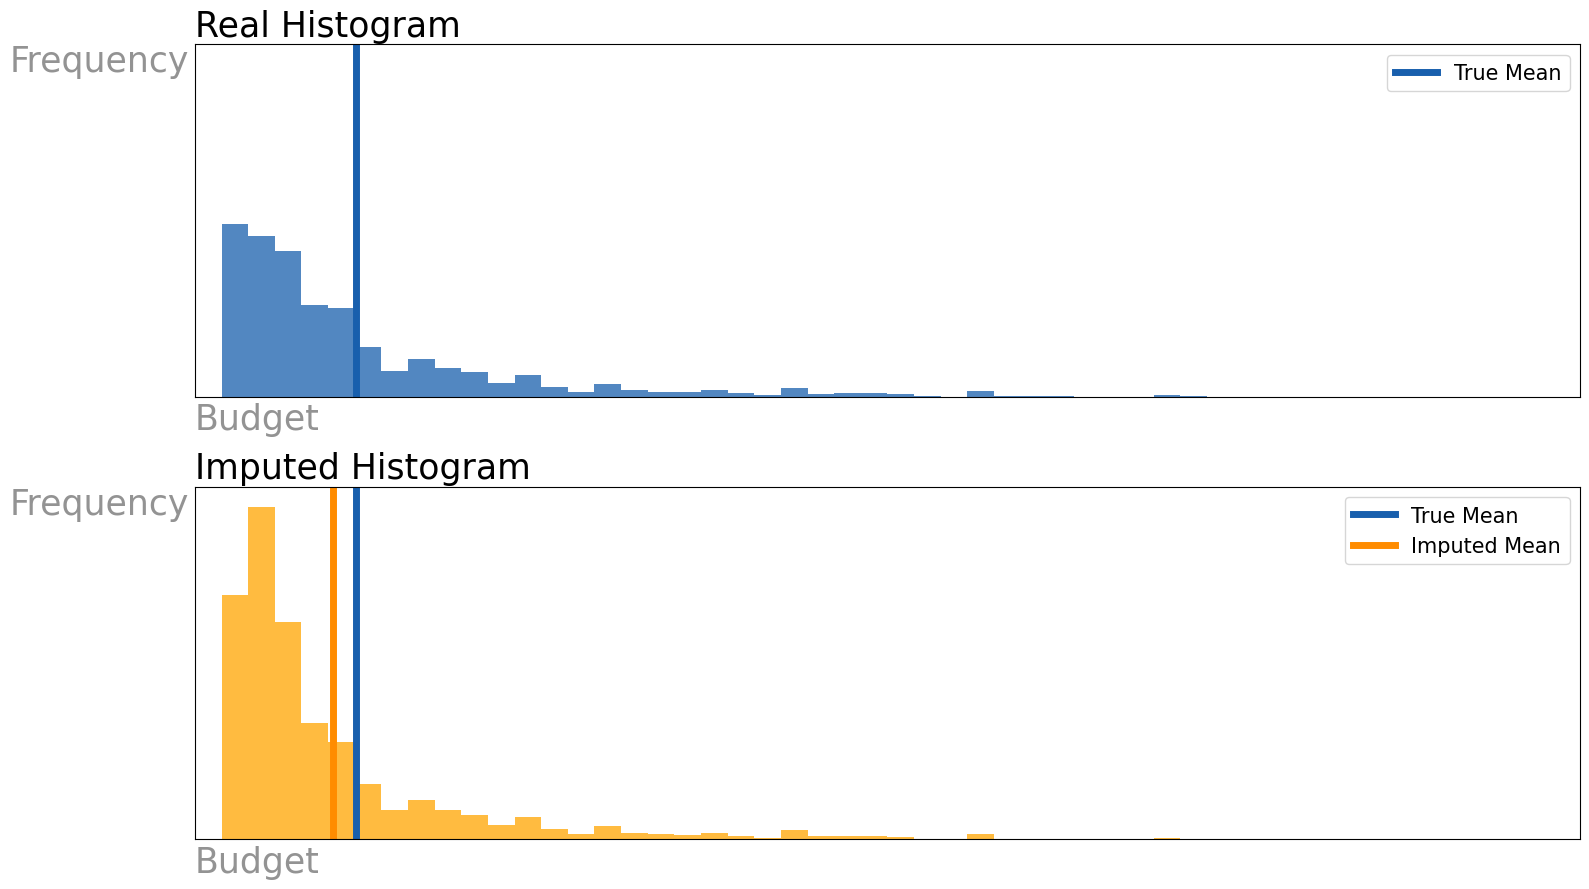

In [82]:
compare_histograms(imputed_column = df['budget'],
                   original_column = df['budget'].where(df['budget_imputed'] == 0),
                   x_label = 'Budget',
                   y_label = 'Frequency')

plt.savefig('./Images/distribution_of_imputed_vs_actual_budget.png', dpi = 192)

In [83]:
df.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,month,rating_labels,rating_imputed,budget_imputed
0,The Shining,4.0,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0,June,R,0,0
1,The Blue Lagoon,4.0,Adventure,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0,July,R,0,0
2,Star Wars: Episode V - The Empire Strikes Back,2.0,Action,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0,June,PG,0,0
3,Airplane!,2.0,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0,July,PG,0,0
4,Caddyshack,4.0,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0,July,R,0,0


In [84]:
df.drop(columns = 'rating_labels', inplace = True)
df.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,month,rating_imputed,budget_imputed
0,The Shining,4.0,Drama,1980,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0,June,0,0
1,The Blue Lagoon,4.0,Adventure,1980,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0,July,0,0
2,Star Wars: Episode V - The Empire Strikes Back,2.0,Action,1980,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0,June,0,0
3,Airplane!,2.0,Comedy,1980,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0,July,0,0
4,Caddyshack,4.0,Comedy,1980,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0,July,0,0


In [85]:
df.to_csv('./Data/imputed.csv', index = False)